<div align='center'  ><img width=200px height=200px src="mindflow.png"></div>

## I- Données

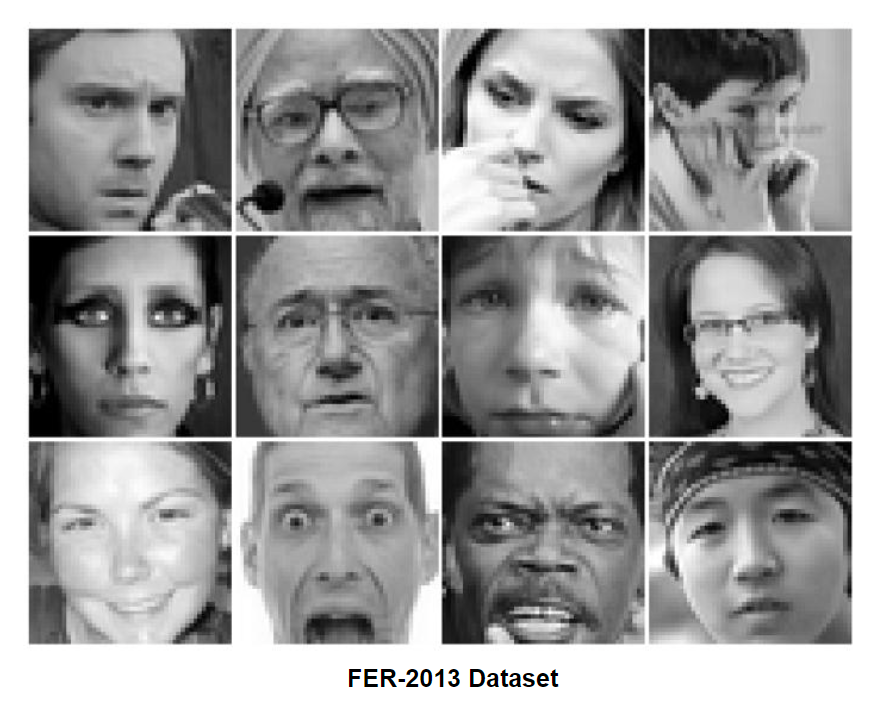

https://www.kaggle.com/datasets/msambare/fer2013?resource=download

Les données présentent dans ce *dataset* consistent en des images de visages en *grayscale* de 48x48 pixels. Les photos ont été automatiquement rognés afin que les visages soient plus ou moins centrés et occupent à peu près la même quantité d'espace dans chaque image.

Chacunes de ces images est labellisée dans une seule des sept catégories d'émotion suivante:

* 0=Angry
* 1=Disgust
* 2=Fear
* 3=Happy
* 4=Sad
* 5=Surprise
* 6=Neutral

### Acquisition des données

In [14]:
from fastai.vision.all import *

In [35]:
fer_data_path = './data/fer'

* Les données étant déja réparties en un training et validation set pour lequels les images sont stockées dans des répertoires correspondant au label, on utilise directement l'objet *ImageDataLoaders* associé à la méthode from_folder
* On applique directement une normalisation sur les données en utilisant des statistiques consolidées sur imagenet


In [63]:
dls = ImageDataLoaders.from_folder(fer_data_path,batch_tfms=Normalize.from_stats(*imagenet_stats),
                                  bs=64)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


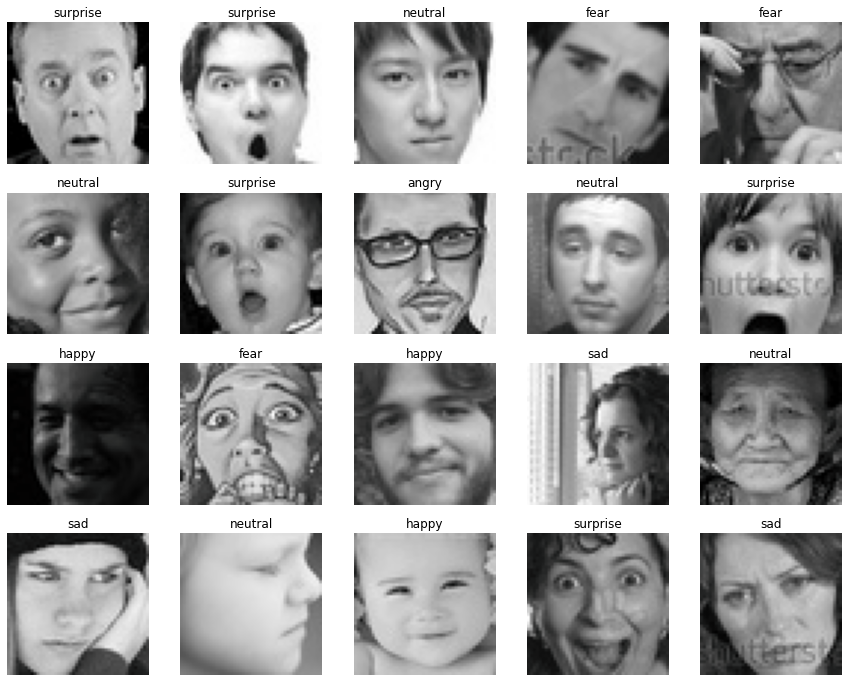

In [43]:
dls.show_batch(max_n=20)

On remarque déja quelques soucis avec la pertinence des labels choisis ainsi que la présence d'un monogramme sur bon nombre d'image. 

In [67]:
print('Training Set size: ', len(dls.train.items) )

Training Set size:  28709


In [68]:
print('Validation Set size: ', len(dls.valid.items) )

Validation Set size:  7178


### Data Augmentation

* On augmente artificiellement la taille de notre dataset en incluant pour chaque images un ensemble de distorsions cadrées aleatoirement

* Cette procedure a de nombreux avantages, elle donne notamment lieu à la reduction de l'apprentissage du *bruit* present dans le training set pour se focaliser sur le *signal* : l'algorithme aura tendance a extraire les caracterisiques fondamentales permettant la reconnaissance d'une émotion et sera moins sensible aux caractéristiques singulière d'une de l'image ( angle, orientation du visage, etc)

In [64]:
dls = ImageDataLoaders.from_folder(fer_data_path,batch_tfms=aug_transforms(mult=2),
                                  bs=64)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


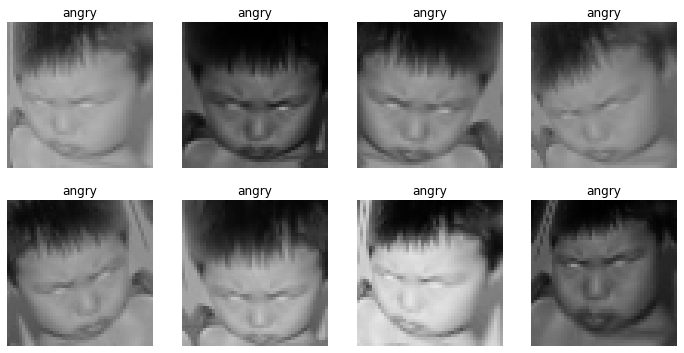

In [65]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [67]:
print('Training Set size: ', len(dls.train.items) )

Training Set size:  28709


In [68]:
print('Validation Set size: ', len(dls.valid.items) )

Validation Set size:  7178


## II -  Apprentissage - Transfert Learning sur une architecture Resnet50

* Pour optimiser la performance de notre CNN à notre cas d'usage, nous n'allons pas nous contenter d'utiliser un CNN vanilla.

![Representation Transfert Learning](img_notebook/cnn_rep_tl.png)

* Notre stratégie d'optimisation est d'utiliser la méthode du transfert learning. Celle-ci consiste à utiliser un modèle déjà pré-entrainer sur des données.Ici en l'occurence on utlise un modèle d'architecture **resnet50** qui déjà été entrainer sur plus de 1.5M d'images à catégoriser plus d'un milliers de classe. L'idée est de tirer profit de cette connaissance accumulée par le modèle, nottament sur les premieres couches du CNN qui contiennent les representation de 'bas niveau' et 'moyen niveau' du contenu d'une image.

![Fine Tuning](img_notebook/fine_tuning.png)


* On tire parti de ces connaisances en n'entrainant que les dernieres couches du CNN pré-entrainé en specifiant un output correspond à nos classes, le reste des couches etant "gelées'. La methode de fine-tuning que nous allons utilser (celle de fastai) va un peu plus loin en selectionnant au hasard une proportions de ces "couches savantes gelées" pour les réentrainer.

* Evaluation : F1 Score, Accuracy, Confusion Matrix, Top Losses Examples, train vs valid accuracy ( surveillance de l'overfitting)

In [73]:
from fastai.test_utils import *

In [110]:
f1score = F1Score(average='macro')

In [111]:
learn = cnn_learner(dls, resnet50, metrics=[f1score,accuracy], pretrained=True,cbs=ShowGraphCallback())


#### Learning rate selection

Introduit par Leslie N. Smith dans *Cyclical Learning Rates for Training Neural Networks*, la méthode *lr_find* entraine le modèle avec des lr croissant exponentielllement puis dessinne le graphe des losses vs the learning rates en echelle log.

L'idée est alors de selectionner le lr situé sur la phase descendante de la courbe la plus abrupte modulo un certain nombre de considérations qui varient selon la methode de suggestion choisie. 

Nous choisissons l'approche *valley* qui semble être la plus utilisée : lr selectionné environ "à mi-chemin" de la meilleure phase descendante.

sources :
* https://arxiv.org/pdf/1506.01186.pdf
* https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

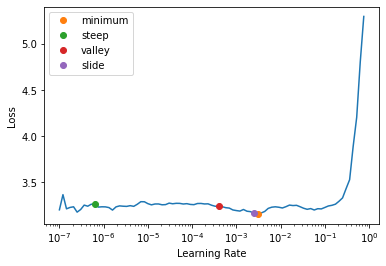

In [112]:
sugg_lr = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [113]:
sugg_lr

SuggestedLRs(minimum=0.0003019951749593019, steep=6.309573450380412e-07, valley=0.0003981071640737355, slide=0.002511886414140463)

In [114]:
lr_star=sugg_lr[2]

#### Entrainement

* On utilise la methode *fine tune*
* On fait 15 epochs sur les données d'entrainement
* On intègre $lr^{*}$ en tant que learning rate 

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,2.503056,2.022318,0.243671,0.311229,01:06


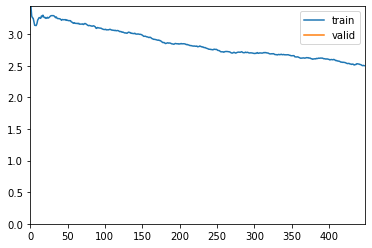

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,2.136936,1.697496,0.277640,0.361939,01:14
1,1.935662,1.597229,0.282021,0.385483,01:14
2,1.757686,1.503188,0.324725,0.426163,01:13
3,1.698419,1.417635,0.372478,0.467261,01:13
4,1.579213,1.373480,0.389951,0.491780,01:13
5,1.542458,1.315610,0.417795,0.509891,01:13
6,1.463396,1.279612,0.427294,0.523405,01:13
7,1.440311,1.222673,0.449209,0.530231,01:13
8,1.385853,1.221052,0.481378,0.544023,01:13
9,1.378487,1.212227,0.489994,0.546949,01:13


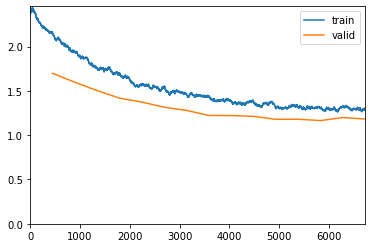

In [115]:
learn.fine_tune(15, lr_star)

La perte sur le validation set est de manière consistante sous la perte sur le training set, le modèle n'overfit pas.
Du fait de ressources limités, nous arretons l'entrainement au 10eme epochs. La tendance globale suggère une stagnation de l'apprentissage.

In [116]:
interp = ClassificationInterpretation.from_learner(learn)

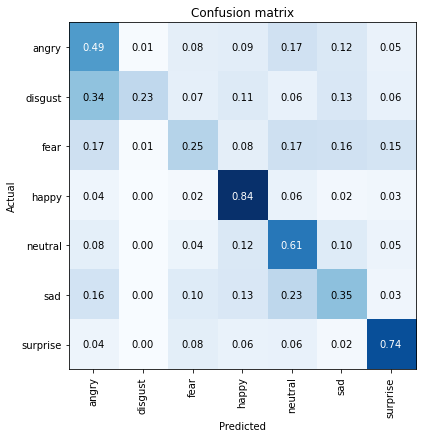

In [117]:
interp.plot_confusion_matrix(figsize=(6,6),normalize=True)

In [118]:
interp.most_confused()

[('sad', 'neutral', 286),
 ('sad', 'angry', 195),
 ('fear', 'angry', 179),
 ('fear', 'neutral', 178),
 ('fear', 'sad', 168),
 ('angry', 'neutral', 159),
 ('sad', 'happy', 156),
 ('fear', 'surprise', 153),
 ('neutral', 'happy', 148),
 ('sad', 'fear', 129),
 ('neutral', 'sad', 128),
 ('angry', 'sad', 115),
 ('happy', 'neutral', 104),
 ('neutral', 'angry', 94),
 ('angry', 'happy', 82),
 ('fear', 'happy', 81),
 ('angry', 'fear', 78),
 ('surprise', 'fear', 69),
 ('happy', 'angry', 67),
 ('neutral', 'surprise', 60),
 ('neutral', 'fear', 54),
 ('surprise', 'neutral', 54),
 ('angry', 'surprise', 51),
 ('happy', 'surprise', 50),
 ('surprise', 'happy', 47),
 ('sad', 'surprise', 43),
 ('happy', 'sad', 39),
 ('disgust', 'angry', 38),
 ('surprise', 'angry', 33),
 ('happy', 'fear', 28),
 ('surprise', 'sad', 16),
 ('disgust', 'sad', 14),
 ('disgust', 'happy', 12),
 ('disgust', 'fear', 8),
 ('disgust', 'neutral', 7),
 ('disgust', 'surprise', 7),
 ('fear', 'disgust', 6),
 ('angry', 'disgust', 5),
 ('sa

In [119]:
learn.metrics

(#2) [<fastai.metrics.AccumMetric object at 0x000001E32D472100>,<fastai.learner.AvgMetric object at 0x000001E32D46CD00>]

In [120]:
learn.save('model_fer_resnet50.pth')

Path('data/fer/models/model_fer_resnet50.pth.pth')

In [121]:
learn.load('model_fer_resnet50.pth')

In [122]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

None

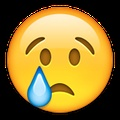

In [24]:
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)

cp = None

def view(button):
    emoji_path = './data/emoji'
    crop_param = (1*20, 1*40)
    haar_cascade = cv2.CascadeClassifier('./data/models/haarcascade_frontalface_default.xml')
    cap = cv2.VideoCapture(0)
    display_handle=display(None, display_id=True)
    display_handle_emoji=display(None, display_id=True)
    i = 0
    while cap.isOpened():
        r , frame = cap.read()
        frame = cv2.flip(frame, 1) # if your camera reverses your image
        #r, frame = cv2.imencode('.jpeg', frame)


        # Par défaut, la frame est en RGB, on la converti en image "niveaux de gris" car c'est ce sur quoi notre modèle a été entrainer
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        #cv2.imshow('Grayscale', gray_frame)
            
        #Extraction des visages present sur la gray_frame grace à l'algorithme de HAAR précedement chargé, nous retourne un itérable de coordonnées spatiales dans la gray_frame correspondantes
        
        visages = haar_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5,
                    minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

            # Grace à chaque coordonnées des visages detectés, on leur applique le rognage spécifié precedemment et les envoient dans le réseau de neurones pour detection
        for visage_coordinates in visages:

            # Extraction des coordonées du visage en cours de traitementn, h étant la hauteur et w la largeur du rectangle correspondant au visage
            X, Y, w, h = visage_coordinates

            # Rognage et extraction de l'image 'niveau de gris' traité du visage en cours de traitement
            x_d, y_d = crop_param
            x1, x2, y1, y2 = (X - x_d, X + w + x_d, Y - y_d, Y + h + y_d)
            


           
            
            try:
                cp_visage = gray_frame[y1:y2, x1:x2]
                cp_visage = cv2.resize(cp_visage, dsize=(48*1, 48*1))
                cv2.imwrite('test.jpg', cp_visage)
                img = cv2.imread('test.jpg',0) 
                emotion_pred_class, pred_idx, outputs = learn.predict(img)
                emotion_prob = float(outputs[np.argmax(outputs)])
                
                
                if str(emotion_pred_class) == 'Happy':
                    emoji = cv2.imread(emoji_path+'/happy.png',1)     
                else:    
                    emoji = cv2.imread(emoji_path+'/sad.png',1)
                      
                cv2.putText(frame,str(emotion_pred_class),(X, Y),cv2.FONT_HERSHEY_SIMPLEX,0.45,(0, 128, 0),2)
                cv2.rectangle(img=frame,pt1=(X, Y),pt2=(X + w, Y + h),color=(0, 0, 0),thickness=2)
                cv2.putText(frame,str(emotion_pred_class) + ' Probability  ' + str(round(emotion_prob,3)*100)+"%",(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255, 255, 255),3)

                #cp = cp_visage.copy()
            except:
                pass


        
        r, frame = cv2.imencode('.jpeg', frame)
        r, emoji = cv2.imencode('.jpeg', emoji)

        display_handle.update(Image(data=frame.tobytes()))
        display_handle_emoji.update(Image(data=emoji.tobytes()))
        if stopButton.value==True:
            cap.release()
            display_handle.update(None)

            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()